# Contents

1. Before we begin
2. G-and-k 
- Inference
- Sqrt n experiment 
- Sensitivity to $\alpha$
- Sensitivity to T
- Sensitivity to l 
3. Gaussian location model 
- Inference 
- Cauchy data with Gaussian model experiment 
4. Toggle Switch

# Before we begin

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import time
py_file_location = "/content/drive/My Drive/NPL_MMD_experiments" # Set folder path in google drive where py and data files are located
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
pip install POT

# G-and-k

In [ ]:
from utils import sample_gandk_outl, k
from plot_functions import plot_posterior_marginals, plot_mse, plot_gnk, SeabornFig2Grid
import NPL
import models
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
# Set paths
data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_gnk/"
results_path = "/content/drive/My Drive/NPL_MMD_experiments/results_gnk/"
#plots_path = "/content/drive/My Drive/NPL_MMD_experiments/"

In [ ]:
# Set model 
model_name = 'gandk' 
n = 2**11
d = 1
theta_star = np.array([3,1,1,-np.log(2)]) 
outl = 1 #3 # number of different percentages of outliers to run for
m = 2**9 # number of samples
l = 1 #0.15  # kernel lengthscale
p = 4   # number of unknown parameters
B = 500 # number of bootstrap iterations 
model = models.g_and_k_model(m,d)
R = 10 # number of independent runs
s=1 # std of Gaussian data

In [ ]:
# Load data
datasets = np.zeros((R,outl,n))
for j in range(R):
    for i in range(outl):
        X = np.loadtxt(data_path+'run_{}_outl_{}'.format(j,i))
        datasets[j,i,:] = X

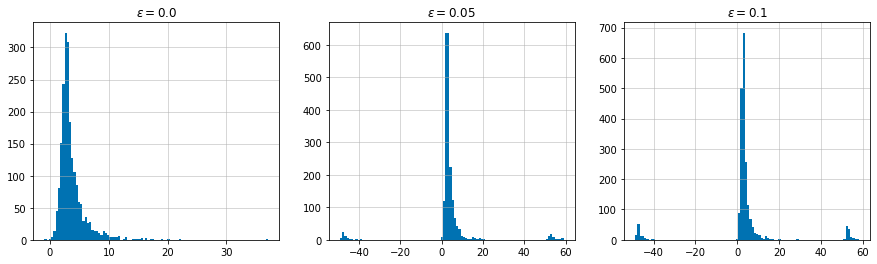

In [ ]:
# Visualise data
X1 =datasets[0,0,:]
X2 = datasets[0,1,:]
X3 = datasets[0,2,:]
fig, axes = plt.subplots(1,3, figsize=(15,4))
for i,ax in enumerate(axes):
  X = datasets[0,i,:]
  ax.hist(X, bins=100, color='#0072B2') 
  ax.set_title(r'$\epsilon = {}$'.format(i*5/100))
  ax.grid(linewidth=0.5)

#plt.savefig('histograms_gnk_densities.png')

### Inference

In [ ]:
# Set model 
model_name = 'gandk' 
n = 2**11
d = 1
theta_star = np.array([3,1,1,-np.log(2)]) 
outl = 1 # number of different percentages of outliers to run for
m = 2**9 # number of samples
l = 0.35  # kernel lengthscale
p = 4   # number of unknown parameters
B = 10 # number of bootstrap iterations 
model = models.g_and_k_model(m,d)
R = 1 # number of independent runs
s=1 # std of Gaussian data
#X = np.random.uniform(low=0.0, high=10.0, size=()))

In [ ]:
# Obtain and save results 
summary_stats = np.zeros((R,outl, p, 4)) # collect mean, median, mode, st.dev for each bootstrap sample
times = []
for j in range(R):
    print("-----Run ", j)
    for n_cont in range(outl):
        print("-----Running for", n_cont*5, "% of outliers-----")
        X =datasets[j,n_cont,:].reshape((n,1))
        npl = NPL.npl(X,B,m,p,l, model = model, model_name = model_name)
        t0 = time.time()
        npl.draw_samples()
        t1 = time.time()
        total = t1-t0
        times.append(total)
        sample = npl.sample
        summary_stats[j,n_cont,:,0] = np.mean(sample, axis=0)
        summary_stats[j,n_cont,:,1] = np.std(sample, axis=0)
        summary_stats[j,n_cont,:,2] = np.median(sample, axis=0)
        summary_stats[j,n_cont,:,3] = stats.mode(sample, axis=0)[0]
        np.savetxt(results_path+'thetas_mmd_run_{}_outl_{}.txt'.format(j,n_cont), sample)
np.savetxt(results_path+'times_gnk_.txt', times)     

In [ ]:
r = 0 # index which run you want results for
# Reshape results
thetas_mmd = np.zeros((p,outl,B))
for i in range(outl):
    for j in range(p):
        sample = np.loadtxt(results_path+'NPL_MMD/thetas_mmd_outl_{}_run_{}.txt'.format(i,r))
        thetas_mmd[j,i,:] = sample[0:500,j]

In [ ]:
names = ["A", "B", "g", "k"]
thetas_wabc = np.zeros((p,outl,B))
for n_cont in range(outl):
    for i,name in enumerate(names):
        df = pd.read_csv(results_path+'WABC/thetas_wabc_outl_{}_run_{}.csv'.format(n_cont,r))
        thetas_wabc[i,n_cont,:] = df[name]
thetas_wabc[3,:,:] = np.log(thetas_wabc[3,:,:])   # last parameter for gandk is exp(k)


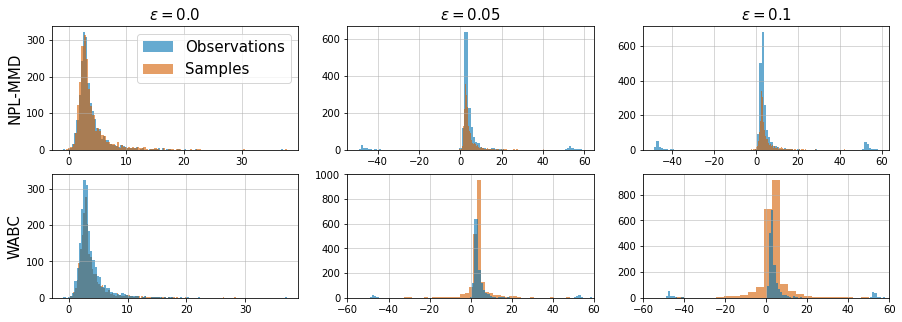

In [ ]:
theta_posterior_means = np.mean(thetas_mmd, axis=2)
theta_posterior_means_wabc = np.mean(thetas_wabc, axis=2)
f, axes = plt.subplots(2,3,figsize=(15,5))
for i,ax in enumerate(axes.flatten()):
  if i <3:
    X = datasets[0,i,:]
    samples = sample_gandk_outl(n,d,theta_posterior_means[:,i])
    #samples_wabc = sample_gandk_outl(n,d,theta_posterior_means_wabc[:,i])
    ax.hist(X, bins=100, color='#0072B2', alpha = 0.6, label='Observations') 
    ax.hist(samples, bins=100, color='#D55E00', alpha=0.6, label='Samples')
    #ax.hist(samples_wabc, bins=100, color='#009E73', alpha=0.6)
    # ax.set_yticklabels(ax.get_yticks(), size = 10)
    # ax.set_xticklabels(ax.get_xticks(), size = 10)
    ax.set_title(r'$\epsilon = {}$'.format(i*5/100), fontsize=15)
    ax.grid(linewidth=0.5)
    if i == 0:
      ax.legend(fontsize=15)
      ax.set_ylabel('NPL-MMD', fontsize=15)
  else:
    X = datasets[0,(i-3),:]
    samples_wabc = sample_gandk_outl(n,d,theta_posterior_means_wabc[:,(i-3)])
    
    ax.hist(samples_wabc, bins=100, color='#D55E00', alpha=0.6)
    ax.hist(X, bins=100, color='#0072B2', alpha = 0.6) 
    #ax.set_title(r'$\epsilon = {}$'.format(i*5/100))
    ax.grid(linewidth=0.5)
    # ax.set_yticklabels(ax.get_yticks(), size = 10)
    # ax.set_xticklabels(ax.get_xticks(), size = 10)
    if i > 3:
      ax.set_xlim(-60,60)
    else:
      ax.set_ylabel('WABC', fontsize=15)
plt.savefig('histogram_sampled_densities.png')

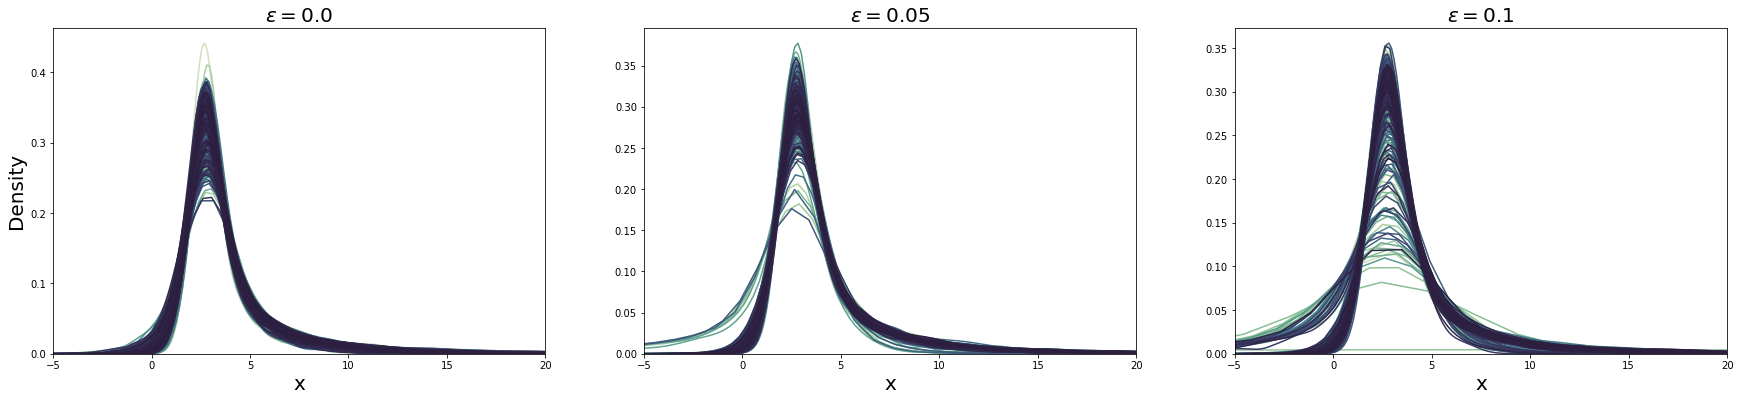

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
outl = 3
pal = sns.cubehelix_palette(start=.5, rot=-.75, n_colors=B)
fig, ax_array = plt.subplots(1, outl, figsize=(30,6))
#label = ['a', 'b', 'g', r'$\log(k)$']
for j,ax in enumerate(ax_array):
  for i in range(B):
    theta = thetas_mmd[:,j,i]
    sample = sample_gandk_outl(n,d,theta)
    ax = sns.kdeplot(sample.flatten(), color=pal[i], ax=ax ) #label='n={}'.format(n),
    ax.set_title(r'$\epsilon = {}$'.format(j*5/100), fontsize=20)
    ax.set_xlim(-5,20)
    ax.set_xlabel('x', fontsize=20)
    if j == 0:
      ax.set_ylabel('Density', fontsize=20)
    else:
      ax.set_ylabel('')

plt.savefig('bootstrap_it_densities.png')

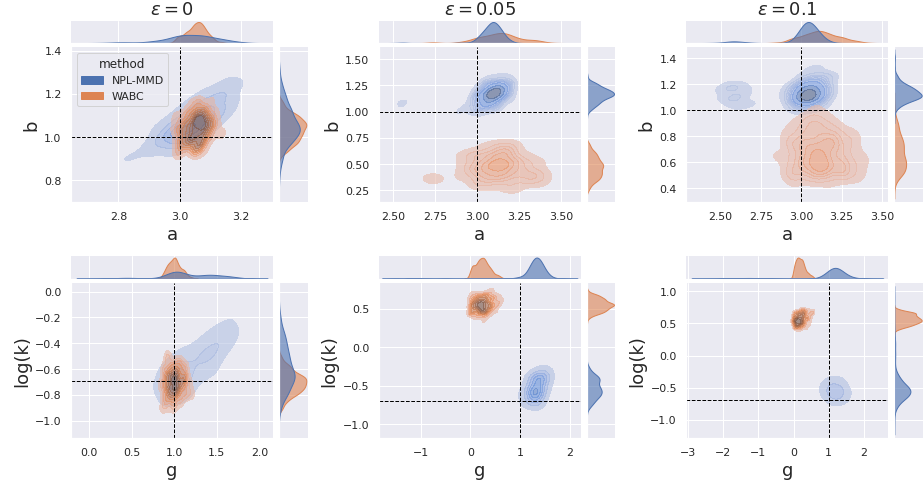

In [ ]:
r = 0 # index which run you want results for
# Reshape results
thetas_mmd = np.zeros((p,outl,B))
for i in range(outl):
    for j in range(p):
        sample = np.loadtxt(results_path+'NPL_MMD/thetas_mmd_outl_{}_run_{}.txt'.format(i,r))
        thetas_mmd[j,i,:] = sample[0:500,j]

names = ["A", "B", "g", "k"]
thetas_wabc = np.zeros((p,outl,B))
for n_cont in range(outl):
    for i,name in enumerate(names):
        df = pd.read_csv(results_path+'WABC/thetas_wabc_outl_{}_run_{}.csv'.format(n_cont,r))
        thetas_wabc[i,n_cont,:] = df[name]
thetas_wabc[3,:,:] = np.log(thetas_wabc[3,:,:])   # last parameter for gandk is exp(k)
      
fig = plt.figure(figsize=(13,7))
gs = gridspec.GridSpec(2, 3)
fname1 = 'run_{}_post_marg'.format(r)
axes = plot_gnk(B,thetas_wabc, thetas_mmd, theta_star,outl, fname1,save_fig=False)
mg0 = SeabornFig2Grid(axes[0], fig, gs[0], '$\epsilon = 0$', add_title=True)
mg1 = SeabornFig2Grid(axes[1], fig, gs[1], '$\epsilon = 0.05$', add_title=True)
mg2 = SeabornFig2Grid(axes[2], fig, gs[2], '$\epsilon = 0.1$', add_title=True)
mg3 = SeabornFig2Grid(axes[3], fig, gs[3], '0%')
mg4 = SeabornFig2Grid(axes[4], fig, gs[4], '0%')
mg5 = SeabornFig2Grid(axes[5], fig, gs[5], '0%')

gs.tight_layout(fig)
plt.savefig(fname1)
plt.show()

## Sqrt n experiment

In [ ]:
def MMD_approx(n,m,kxx,kxy,kyy):
        """ Approximates the MMD between P_\theta with y_{i=1}^m iid sample from P_\theta and
        P^j = \sum_{i=1}^n w^j_i \delta_{x_i}
        """
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,m)) # excludes k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        sum2 = np.sum(kxy)
    
        # third sum
        np.fill_diagonal(kxx, np.repeat(0,n))
        sum3 = np.sum(kxx)
    
        #return (1/(m*(m-1)))*sum1-(2/(n*m))*sum2+(1/(n*(n-1)))*sum3
        return (1/(m*(m-1)))*sum1-(2/(n*m))*sum2+(1/(n*(n-1)))*sum3

In [ ]:
n_range = np.linspace(250,4000,num=10,  dtype=int)
model_name = 'gandk' # set to gaussian or gandk or toggle_switch
m = 2**9 # number of samples
l = 0.15  # kernel lengthscale
p = 4 # number of unknown parameters
B = 500 # number of bootstrap iterations 
R = 10
mmd_dists = np.zeros((len(n_range), R))
d = 1
theta_star = np.array([3,1,1,-np.log(2)]) 
outl = 1 # number of different percentages of outliers to run for
model = models.g_and_k_model(m,d)
theta_samples = np.zeros((len(n_range),B,p))
for i, n in enumerate(n_range):
  print(n)
  for r in range(R):
    X = sample_gandk_outl(n,d,theta_star)
    #np.savetxt('/content/drive/My Drive/sample_for_divs_20_{}'.format(n), X)
    npl_ = NPL.npl(X,B,m,p,l, model = model, model_name = model_name)
    npl_.draw_samples()
    theta_est = np.mean(npl_.sample, axis=0)
    M = 15000
    x = sample_gandk_outl(M,d,theta_star)
    y = sample_gandk_outl(M,d,theta_est)
    kxx = k(x,x,l)[0]
    kxy = k(y,x,l)[0]
    kyy = k(y,y,l)[0]
    mmd_dists[i,r] = MMD_approx(M,M,kxx,kxy,kyy)

250
666
1083
1500
1916
2333
2750
3166
3583
4000


Text(0.5, 0, 'n')

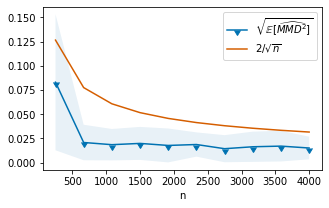

In [ ]:
plt.figure(figsize=(5, 3))

plt.plot(n_range, np.sqrt(np.mean(mmd_dists, axis=1)), label='$\sqrt{\mathbb{E}[\widehat{MMD}^2]}$',marker=11, color='#0072B2')
plt.fill_between(n_range, np.sqrt(np.mean(mmd_dists, axis=1))-np.sqrt(np.std(mmd_dists, axis=1)), np.sqrt(np.mean(mmd_dists, axis=1))+np.sqrt(np.std(mmd_dists, axis=1)), alpha=0.1)

plt.plot(n_range, 2/np.sqrt(n_range), label='$2/\sqrt{n}$', color='#D55E00')
plt.legend()
plt.xlabel('n')

## Sensitivity to α

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import time
py_file_location = "/content/drive/My Drive/NPL_MMD_experiments"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
pip install POT

In [ ]:
# Set paths
data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_gnk_alpha_exp/"
results_path = "/content/drive/My Drive/NPL_MMD_experiments/results_gnk_alpha_exp/"

In [ ]:
# Set model 
model_name = 'gandk' 
n = 2**11
d = 1
theta_star = np.array([3,1,1,-np.log(2)]) 
outl = 3 # number of different percentages of outliers to run for
m = 2**9 # number of samples
l = 0.15  # kernel lengthscale 0.15
p = 4   # number of unknown parameters
B = 500 # number of bootstrap iterations 
model = g_and_k_model(m,d)
R = 1 # number of independent runs
s=1 # std of Gaussian data

In [ ]:
# Range of alphas 
alphas = np.linspace(0.01,300,num=10)

In [ ]:
datasets = np.zeros((outl,n))
for i in range(outl):
    #X = sample_gandk_outl(n,d,theta_star, n_cont=i).reshape((n,))
    #np.savetxt(data_path+'alpha_exp_outl_{}'.format(i), X)
    X = np.loadtxt(data_path+'alpha_exp_outl_{}'.format(i))
    datasets[i,:] = X

In [ ]:
theta_samples = np.zeros((len(alphas),outl,B,p))

In [ ]:
T = 2**11
for i, a in enumerate(alphas):
   print(a)
   for j in range(outl):
     X = datasets[j,:].reshape((n,d))
     npl_ = npl(X,B,m,s, p,l, model = model, a=a, T=T, model_name = model_name)
     npl_.draw_samples()
     sample = npl_.sample
     theta_samples[i,j,:,:] = sample
     np.savetxt(results_path+'alpha_exp_theta_outl_{}_alpha_{}_T_{}_2.txt'.format(j,a,T), sample)

0.01
33.34222222222222
66.67444444444445
100.00666666666667
133.33888888888887
166.6711111111111
200.00333333333333
233.33555555555554
266.66777777777776
300.0


In [ ]:
T = 2**11
for i, a in enumerate(alphas):
  for j in range(outl):
    theta_samples[i,j,:,:] = np.loadtxt(results_path+'alpha_exp_theta_outl_{}_alpha_{}_T_{}_2.txt'.format(j,a,T))

In [ ]:
mean_theta_samples = np.mean(theta_samples, axis=2)

[[0.00510443 0.01817417 0.02602175]
 [0.00556862 0.03045324 0.03236693]
 [0.00463566 0.04127947 0.04623909]
 [0.0044487  0.05495518 0.05746311]
 [0.00373412 0.06987396 0.06360731]
 [0.0035445  0.09067717 0.09676833]
 [0.00333712 0.11642987 0.12604514]
 [0.0049615  0.14212918 0.15920375]
 [0.00519799 0.17561358 0.17927248]
 [0.00538664 0.21184246 0.21773051]]


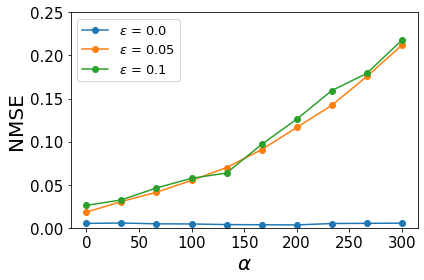

In [ ]:
# Function to calculate mse 
def mse(thetas,theta_star):
    mse_ = np.mean(np.asarray((thetas-theta_star))**2)
    return mse_

def nmse(theta,theta_star):
    mse_ = np.mean(np.asarray((theta-theta_star))**2)/np.mean(theta_star)
    return mse_

mses = np.zeros((len(alphas),outl))
   
for i in range(len(alphas)):
  for j in range(outl):
    mses[i,j] = nmse(mean_theta_samples[i,j,:], theta_star)
            
print(mses)

for j in range(outl):
  plt.plot(alphas, mses[:,j], marker='o', label=r'$\epsilon$ = {}'.format(j*5/100))
  plt.xlabel(r'$\alpha$', fontsize=20)
  plt.ylabel('NMSE', fontsize=20)
  plt.ylim(bottom=0) 
  plt.ylim(top=0.25)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.legend(prop={"size":13})
plt.tight_layout() 
plt.savefig(results_path+'T=2**11_2.png')

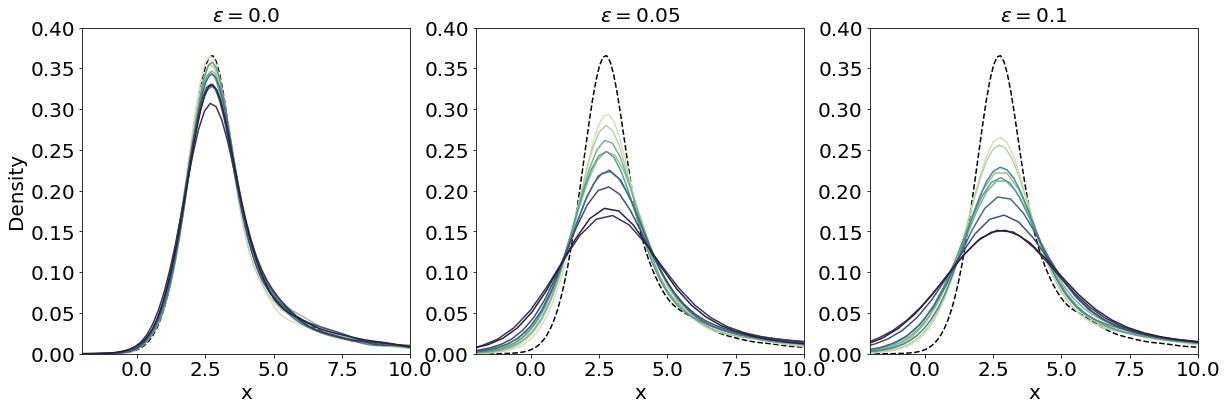

In [ ]:
import seaborn as sns
pal = sns.cubehelix_palette(start=.5, rot=-.75, n_colors=len(alphas))
fig, ax_array = plt.subplots(1, outl, figsize=(20,6))
for j,ax in enumerate(ax_array):
  ax = sns.kdeplot(datasets[0,:].flatten(), ax=ax, linestyle="--", color="black")
  for i in range(len(alphas)):
    theta = mean_theta_samples[i,j,:]
    sample = sample_gandk_outl(n,d,theta, n_cont=0).reshape((n,))
    ax = sns.kdeplot(sample.flatten(), color=pal[i], ax=ax) 
    ax.set_title(r'$\epsilon = {}$'.format(j*5/100), fontsize=20)
    ax.set_xlim(-2,10)
    ax.set_ylim(0,0.4)
    ax.set_xlabel('x', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if j == 0:
      ax.set_ylabel('Density', fontsize=20)
    else:
      ax.set_ylabel('')

plt.savefig(results_path+'alpha_exps_2.png')



## Sensitivity to Τ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import time
py_file_location = "/content/drive/My Drive/NPL_MMD_experiments"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
pip install POT

In [ ]:
# Set paths
data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_gnk_alpha_exp/"   # use same data as in the alpha sensitivity experiment 
results_path = "/content/drive/My Drive/NPL_MMD_experiments/results_gnk_T_exp/"

In [ ]:
# Set model 
model_name = 'gandk' 
n = 2**11
d = 1
theta_star = np.array([3,1,1,-np.log(2)]) 
outl = 3 # number of different percentages of outliers to run for
m = 2**9 # number of samples
l = 0.15  # kernel lengthscale
p = 4   # number of unknown parameters
B = 500 # number of bootstrap iterations 
model = g_and_k_model(m,d)
R = 1 # number of independent runs
s=1 # std of Gaussian data

In [ ]:
# Range of T 
Ts = [10,100,500,1000,2000,5000]

In [ ]:
datasets = np.zeros((outl,n))
for i in range(outl):
    #X = sample_gandk_outl(n,d,theta_star, n_cont=i).reshape((n,))
    #np.savetxt(data_path+'alpha_exp_outl_{}'.format(i), X)
    X = np.loadtxt(data_path+'alpha_exp_outl_{}'.format(i))
    datasets[i,:] = X

In [ ]:
theta_samples = np.zeros((len(Ts),outl,B,p))

In [ ]:
a = 0.1  # keep a fixed
for i, T in enumerate(Ts):
   print(T)
   for j in range(outl):
     X = datasets[j,:].reshape((n,d))
     npl_ = npl(X,B,m,s, p,l, model = model, a=a, T=T, model_name = model_name)
     npl_.draw_samples()
     sample = npl_.sample
     theta_samples[i,j,:,:] = sample
     np.savetxt(results_path+'T_exp_theta_outl_{}_alpha_{}_T_{}_2.txt'.format(j,a,T), sample)

10
100
500
1000
2000
5000


In [ ]:
a = 0.1
for i, T in enumerate(Ts):
  for j in range(outl):
    theta_samples[i,j,:,:] = np.loadtxt(results_path+'T_exp_theta_outl_{}_alpha_{}_T_{}_2.txt'.format(j,a,T))

In [ ]:
mean_theta_samples = np.mean(theta_samples, axis=2)

[[0.00546823 0.0186448  0.02530528]
 [0.00596466 0.01774017 0.02373565]
 [0.00560923 0.01690986 0.02631271]
 [0.00566819 0.01996547 0.03030345]
 [0.00487111 0.01745802 0.028353  ]
 [0.00520261 0.02020984 0.02793754]]


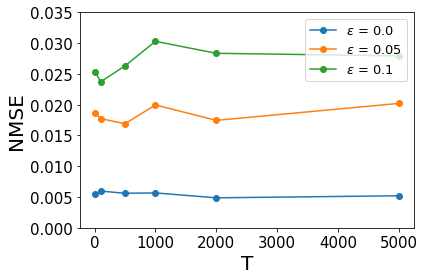

In [ ]:
# Function to calculate mse 
def mse(thetas,theta_star):
    mse_ = np.mean(np.asarray((thetas-theta_star))**2)
    return mse_

def nmse(theta,theta_star):
    mse_ = np.mean(np.asarray((theta-theta_star))**2)/np.mean(theta_star)
    return mse_

mses = np.zeros((len(Ts),outl))
   
for i in range(len(Ts)):
  for j in range(outl):
    mses[i,j] = nmse(mean_theta_samples[i,j,:], theta_star)
            
print(mses)

for j in range(outl):
  plt.plot(Ts, mses[:,j], marker='o', label=r'$\epsilon$ = {}'.format(j*5/100))
  plt.xlabel('T', fontsize=20)
  plt.ylabel('NMSE', fontsize=20)
  plt.ylim(bottom=0) 
  plt.ylim(top=0.035)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.legend(prop={"size":13})
plt.tight_layout() 
plt.savefig(results_path+'a=0.1_2.png')

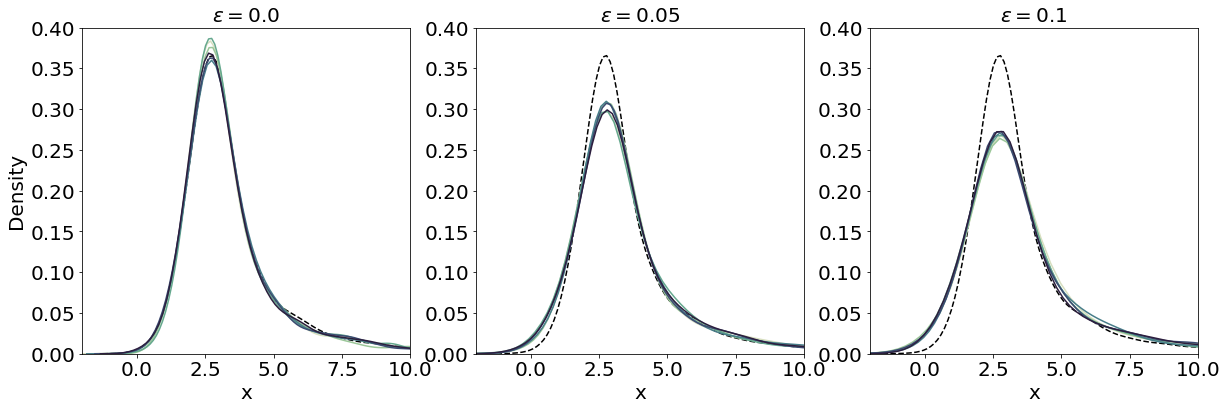

In [ ]:
import seaborn as sns
pal = sns.cubehelix_palette(start=.5, rot=-.75, n_colors=len(Ts))
fig, ax_array = plt.subplots(1, outl, figsize=(20,6))
for j,ax in enumerate(ax_array):
  ax = sns.kdeplot(datasets[0,:].flatten(), ax=ax, linestyle="--", color="black")
  for i in range(len(Ts)):
    theta = mean_theta_samples[i,j,:]
    sample = sample_gandk_outl(n,d,theta, n_cont=0).reshape((n,))
    ax = sns.kdeplot(sample.flatten(), color=pal[i], ax=ax) 
    ax.set_title(r'$\epsilon = {}$'.format(j*5/100), fontsize=20)
    ax.set_xlim(-2,10)
    ax.set_ylim(0,0.4)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('x', fontsize=20)
    if j == 0:
      ax.set_ylabel('Density', fontsize=20)
    else:
      ax.set_ylabel('')

plt.savefig(results_path+'T_exps_a=0.1_2.png')



## Sensitivity to l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
import time
py_file_location = "/content/drive/My Drive/NPL_MMD_experiments"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
pip install POT

In [ ]:
# Set paths
data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_gnk_alpha_exp/"
results_path = "/content/drive/My Drive/NPL_MMD_experiments/results_gnk_l_exp/"

In [ ]:
# Set model 
model_name = 'gandk' 
n = 2**11
d = 1
theta_star = np.array([3,1,1,-np.log(2)]) 
outl = 3 # number of different percentages of outliers to run for
m = 2**9 # number of samples
l = 0.15  # kernel lengthscale
p = 4   # number of unknown parameters
B = 500 # number of bootstrap iterations 
model = g_and_k_model(m,d)
R = 1 # number of independent runs
s=1 # std of Gaussian data

In [ ]:
# Range of ls
ls = np.array([10**(-1), 10**(-0.5), 10**0, 10**(0.5), 10**1, 10**(1.5), 10**2])

In [ ]:
outl = 3
datasets = np.zeros((outl,n))
for i in range(outl):
    #X = sample_gandk_outl(n,d,theta_star, n_cont=i).reshape((n,))
    #np.savetxt(data_path+'alpha_exp_outl_{}'.format(i), X)
    X = np.loadtxt(data_path+'alpha_exp_outl_{}'.format(i))
    datasets[i,:] = X

In [ ]:
theta_samples = np.zeros((len(ls),outl,B,p))

In [ ]:
T = n
a = 0.01
for i, l in enumerate(ls):
   print(l)
   for j in range(outl):
     X = datasets[j,:].reshape((n,d))
     npl_ = npl(X,B,m,s, p,l, model = model, a=a, T=T, model_name = model_name)
     #t0 = time.time()
     npl_.draw_samples()
     #t1 = time.time()
     #total = t1-t0
     #times.append(total)
     sample = npl_.sample
     theta_samples[i,j,:,:] = sample
     np.savetxt(results_path+'alpha_exp_theta_outl_{}_l_{}_new.txt'.format(j,l), sample)

0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
31.622776601683793
100.0


In [ ]:
a = 0.1
T = 2**11
for i, l in enumerate(ls):
  for j in range(outl):
    theta_samples[i,j,:,:] = np.loadtxt(results_path+'alpha_exp_theta_outl_{}_l_{}_new.txt'.format(j,l))

In [ ]:
mean_theta_samples = np.mean(theta_samples, axis=2)

[[4.01290653e-03 2.52347868e-02            nan]
 [3.51715427e+01 1.70411471e+01 4.93679289e-02]
 [2.96881181e+01 3.33858073e+01 3.62550095e+01]
 [1.43501277e+01 1.45620664e+01 1.46894771e+01]
 [1.34550198e+01 1.35742492e+01 1.33272318e+01]
 [1.16528325e+01 1.11723745e+01 1.20639645e+01]
 [1.27079745e+01 1.44606066e+01 1.56639736e+01]]


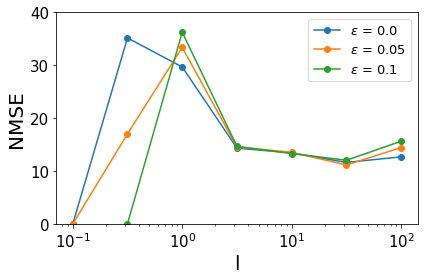

In [ ]:
# Function to calculate mse 
def mse(thetas,theta_star):
    mse_ = np.mean(np.asarray((thetas-theta_star))**2)
    return mse_

def nmse(theta,theta_star):
    mse_ = np.mean(np.asarray((theta-theta_star))**2)/np.mean(theta_star)
    return mse_

mses = np.zeros((len(ls),outl))
   
for i in range(len(ls)):
  for j in range(outl):
    mses[i,j] = nmse(mean_theta_samples[i,j,:], theta_star)
            
print(mses)

for j in range(outl):
  plt.plot(ls, mses[:,j], label=r'$\epsilon$ = {}'.format(j*5/100), marker='o')
  plt.xscale('log', basex=10)
  plt.xlabel('l', fontsize=20)
  plt.ylabel('NMSE', fontsize=20)
  plt.ylim(bottom=0) 
  plt.ylim(top=40)
  plt.tick_params(axis='both', which='major', labelsize=15)
  plt.legend(prop={"size":13})
plt.tight_layout() 
plt.savefig(results_path+'l_exp_mses_2_new.png')

In [ ]:
thetas = np.linspace(-40,40,num=200)
X1 = datasets[0,:].reshape((n,d))
ls = [0.15,1.,10.]
kxx = k(X1,X1,l)[0]
mmds = np.zeros((len(ls),len(thetas)))
for j,l in enumerate(ls):
  for i,theta in enumerate(thetas):
    thetaa = np.array([3,1,theta,-np.log(2)])
    y = sample_gandk_outl(n,d,thetaa)
    kxy = k(y,X1,l)[0]
    kyy = k(y,y,l)[0]
    mmd = MMD_approx(n,n,kxx,kxy,kyy)
    mmds[j,i] = mmd


In [ ]:
thetas = np.linspace(-40,40,num=200)
X1 = datasets[0,:].reshape((n,d))
ls = [0.15,1.,10.]
kxx = k(X1,X1,l)[0]
mmds = np.zeros((200,3))
for j,l in enumerate(ls):
  for i,theta in enumerate(thetas):
    thetaa = np.array([3,1,theta,-np.log(2)])
    y = sample_gandk_outl(n,d,thetaa)
    kxy = k(y,X1,l)[0]
    kyy = k(y,y,l)[0]
    mmd = MMD_approx(n,n,kxx,kxy,kyy)
    mmds[i,j] = mmd

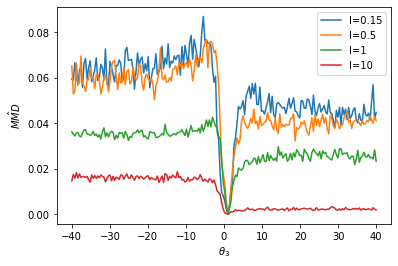

In [ ]:
plt.plot(thetas,mmds_1, label='l=0.15')
plt.plot(thetas,mmds_05, label='l=0.5')
plt.plot(thetas,mmds_015,label='l=1')
plt.plot(thetas,mmds_10, label='l=10')
plt.xlabel(r'$\theta_3$')
plt.ylabel(r'$\hat{MMD}$')
plt.legend()
plt.savefig('losses_theta_3.png')

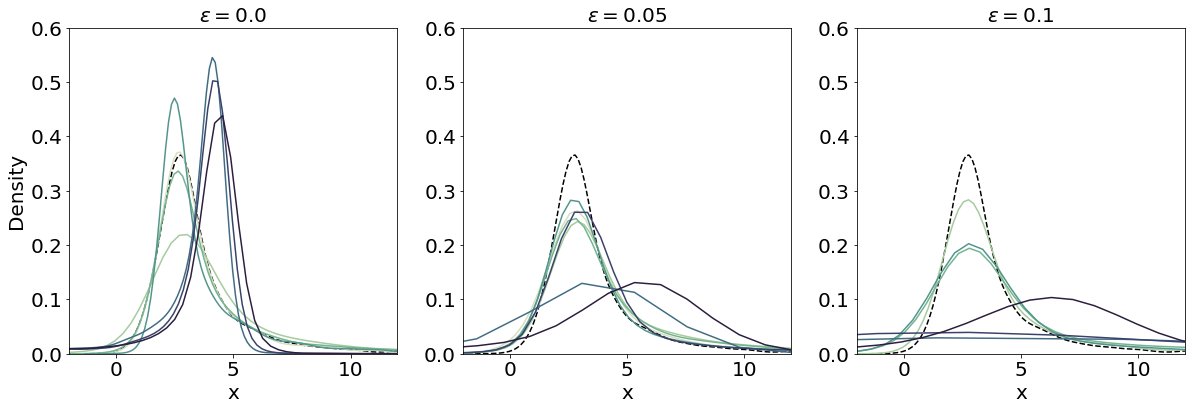

In [ ]:
pal = sns.cubehelix_palette(start=.5, rot=-.75, n_colors=len(ls))
fig, ax_array = plt.subplots(1, outl, figsize=(20,6))
for j,ax in enumerate(ax_array):
  ax = sns.kdeplot(datasets[0,:].flatten(), ax=ax, linestyle="--", color="black")
  for i in range(len(ls)):
    theta = mean_theta_samples[i,j,:]
    sample = sample_gandk_outl(n,d,theta, n_cont=0).reshape((n,))
    ax = sns.kdeplot(sample.flatten(), color=pal[i], ax=ax) 
    ax.set_title(r'$\epsilon = {}$'.format(j*5/100), fontsize=20)
    ax.set_xlim(-2,12)
    ax.set_ylim(0,0.6)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('x', fontsize=20)
    if j == 0:
      ax.set_ylabel('Density', fontsize=20)
    else:
      ax.set_ylabel('')

plt.savefig(results_path+'l_exps_2_new.png')



# Gaussian location model

In [ ]:
from utils import sample_gaussian_outl
from plot_functions import plot_posterior_marginals, plot_mse
import numpy as np
import NPL
import models
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
# Set paths
#data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_gauss/"
data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_lor_gauss/"
results_path = "/content/drive/My Drive/NPL_MMD_experiments/results_missp_gauss/"

## Inference

In [ ]:
# Set model 
model_name = 'gaussian' 
#n = 200
n = 200
#d = 4
#theta_star = np.array([1,1,np.exp(1), np.exp(1)])
d=1
theta_star = np.zeros(d)
s = 1 # std for gaussian model
#outl = 3 # number of different percentages of outliers to run for
m = 500 # number of samples
l = -1  # kernel lengthscale
p = d  # number of unknown parameters
B = 2000 # number of bootstrap iterations 
model = models.gauss_model(m,d,s)
#R = 10 # number of independent runs
R=1

In [ ]:
# Load data
datasets = np.zeros((R,outl,n,d))
for j in range(R):
    for i in range(outl):
        X = np.loadtxt(data_path+'run_{}_outl_{}_dim_{}'.format(j,i,d))
        datasets[j,i,:,:] = X

In [ ]:
# Obtain and save results
summary_stats = np.zeros((R,outl, p, 4)) # collect mean, median, mode, st.dev for each bootstrap sample
summary_stats_wll = np.zeros((R,outl, p, 4))
times = []
for j in range(R):
    print("-----Run ", j)
    for n_cont in range(outl):
        print("-----Running for", n_cont*5, "% of outliers-----")
        X =datasets[j,n_cont,:,:].reshape((n,d))
        npl = NPL.npl(X,B,m,p,l, model = model, model_name = model_name)
        t0 = time.time()
        npl.draw_samples()
        t1 = time.time()
        total = t1-t0
        times.append(total)
        sample = npl.sample
        wll_sample = npl.wll_sample
        wasserstein_sample = npl.was
        summary_stats[j,n_cont,:,0] = np.mean(sample, axis=0)
        summary_stats_wll[j,n_cont,:,0] = np.mean(wll_sample, axis=0)
        summary_stats[j,n_cont,:,1] = np.std(sample, axis=0)
        summary_stats_wll[j, n_cont, :, 1] = np.std(wll_sample, axis=0)
        summary_stats[j,n_cont,:,2] = np.median(sample, axis=0)
        summary_stats_wll[j,n_cont,:,2] = np.median(wll_sample, axis=0)
        summary_stats[j,n_cont,:,3] = stats.mode(sample, axis=0)[0]
        summary_stats_wll[j,n_cont,:,3] =  stats.mode(wll_sample, axis=0)[0]
        np.savetxt(results_path+'NPL_MMD/thetas_mmd_outl_{}_run_{}_dim_{}.txt'.format(n_cont,j,d), sample)
        np.savetxt(results_path+'NPL_WLL/thetas_wll_outl_{}_run_{}_dim_{}.txt'.format(n_cont,j,d), wll_sample)
        np.savetxt(results_path+'NPL_WAS/thetas_was_outl_{}_run_{}_dim_{}.txt'.format(n_cont,j,d), was_sample)
summary_stats = summary_stats.reshape((summary_stats.shape[0], -1))   
summary_stats_wll = summary_stats_wll.reshape((summary_stats_wll.shape[0], -1))    
np.savetxt(results_path+'times_gauss.txt', times)      
np.savetxt(results_path+'NPL_MMD/summary_stats.txt', summary_stats)
np.savetxt(results_path+'NPL_WLL/summary_stats.txt', summary_stats_wll)

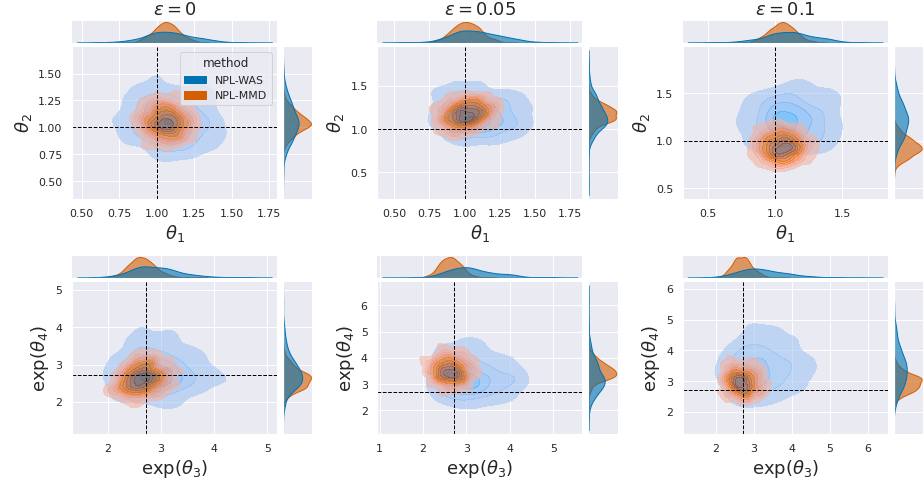

In [ ]:
from plot_functions import plot_gauss_4d
r = 1 # index which run you want results for
# Reshape results
thetas_mmd = np.zeros((p,outl,B))
thetas_wll = np.zeros((p,outl,B))
thetas_was = np.zeros((p,outl,B))
thetas_was = np.zeros((p,outl,B))
for i in range(outl):
    for j in range(p):
        sample = np.loadtxt(results_path+'NPL_MMD/thetas_mmd_outl_{}_run_{}_dim_{}.txt'.format(i,r,d))
        sample_wll = np.loadtxt(results_path+'NPL_WLL/thetas_wll_outl_{}_run_{}_dim_{}.txt'.format(i,r,d))
        sample_was = np.loadtxt(results_path+'NPL_WAS/thetas_mmd_outl_{}_run_{}_dim_{}_.txt'.format(i,r,d))
        if p>1:
            thetas_mmd[j,i,:] = sample[:,j]
            thetas_wll[j,i,:] = sample_wll[:,j]
            thetas_was[j,i,:] = sample_was[:,j]
        else:
            thetas_mmd[j,i,:] = sample
            thetas_wll[j,i,:] = sample_wll
            thetas_was[j,i,:] = sample_was
thetas_mmd[2,:,:] = np.exp(thetas_mmd[2,:,:])
thetas_mmd[3,:,:] = np.exp(thetas_mmd[3,:,:])
thetas_wll[2,:,:] = np.exp(thetas_wll[2,:,:])
thetas_wll[3,:,:] = np.exp(thetas_wll[3,:,:])
thetas_was[2,:,:] = np.exp(thetas_was[2,:,:])
thetas_was[3,:,:] = np.exp(thetas_was[3,:,:])
   
names = ["X1", "X2", "X3", "X4"]
thetas_wabc = np.zeros((p,outl,B))
for n_cont in range(outl):
    for i,name in enumerate(names):
        df = pd.read_csv(results_path+'WABC/thetas_wabc_outl_{}_run_{}_dim_{}.csv'.format(n_cont,r,d))
        thetas_wabc[i,n_cont,:] = df[name]
thetas_wabc[2,:,:] = np.exp(thetas_wabc[2,:,:])
thetas_wabc[3,:,:] = np.exp(thetas_wabc[3,:,:])
      
# Plot results
# Set names for save figures
fname1 = results_path+'gauss_dim_{}_run_{}_post_marg'.format(d,r)

fig = plt.figure(figsize=(13,7))
gs = gridspec.GridSpec(2, 3)
fname1 = 'run_{}_post_marg_was'.format(r)
axes = plot_gauss_4d(B,thetas_wabc, thetas_mmd, thetas_wll, thetas_was, theta_star,outl, fname1,save_fig=False)
mg0 = SeabornFig2Grid(axes[0], fig, gs[0], '$\epsilon = 0$', add_title=True)
mg1 = SeabornFig2Grid(axes[1], fig, gs[1], '$\epsilon = 0.05$', add_title=True)
mg2 = SeabornFig2Grid(axes[2], fig, gs[2], '$\epsilon = 0.1$', add_title=True)
mg3 = SeabornFig2Grid(axes[3], fig, gs[3], '0%')
mg4 = SeabornFig2Grid(axes[4], fig, gs[4], '0%')
mg5 = SeabornFig2Grid(axes[5], fig, gs[5], '0%')

gs.tight_layout(fig)
plt.savefig(fname1)
plt.show()



## Cauchy data with Gaussian model experiment

In [ ]:
def mse(theta,theta_star):
    mse_ = np.mean(np.asarray((theta-theta_star))**2)
    return mse_

In [ ]:
R = 20 
mses = np.zeros((R,3))
for j in range(R):
    print("-----Run ", j)
    X = np.random.standard_cauchy(size=(n,d))
    np.savetxt(results_path+'dataset_run_{}.txt'.format(j),X)
    npl = NPL.npl(X,B,m,p,l, model = model, model_name = model_name)
    npl.draw_samples()
    sample = npl.sample
    wll_sample = npl.wll_sample
    mu_post = (1/25 + n)**(-1)*sum(X.flatten())
    sigma_post = np.sqrt((1/25 + n)**(-1))
    bayes_sample = np.random.normal(mu_post, sigma_post, B)   
    mse_mmd = mse(sample,theta_star)
    mse_wll = mse(wll_sample,theta_star)
    mse_bayes = mse(bayes_sample, theta_star)
    mses[j,:] = np.array([mse_mmd, mse_wll, mse_bayes])
    np.savetxt(results_path+'thetas_mmd_run_{}.txt'.format(j), sample)
    np.savetxt(results_path+'thetas_wll_run_{}.txt'.format(j), wll_sample)
    np.savetxt(results_path+'thetas_bayes_run_{}.txt'.format(j), bayes_sample)

-----Run  0
(200,)
-----Run  1
(200,)
-----Run  2
(200,)
-----Run  3
(200,)
-----Run  4
(200,)
-----Run  5
(200,)
-----Run  6
(200,)
-----Run  7
(200,)
-----Run  8
(200,)
-----Run  9
(200,)
-----Run  10
(200,)
-----Run  11
(200,)
-----Run  12
(200,)
-----Run  13
(200,)
-----Run  14
(200,)
-----Run  15
(200,)
-----Run  16
(200,)
-----Run  17
(200,)
-----Run  18
(200,)
-----Run  19
(200,)


In [ ]:
import pandas
average_mses = np.mean(mses, axis=0)
df = pandas.DataFrame([average_mses], columns=['NPL-MMD','NPL-WLL','Standard-Bayes'])
df.index = ['Average MSE']

In [ ]:
df

,NPL-MMD,NPL-WLL,Standard-Bayes
Average MSE,0.028924,48.229468,28.588448


In [ ]:
#wll_sample = npl.wll_sample
mu_post = (1/25 + 200)**(-1)*sum(X.flatten())
print(mu_post)
sigma_post = np.sqrt((1/25 + 200)**(-1))
print(sigma_post)
bayes_samples = np.random.normal(mu_post, sigma_post, B)

-0.49685709776299813
0.07070360811132631


In [ ]:
np.savetxt(results_path+'nplmmd_standard_cauchy_n200_B2000.txt', sample)
np.savetxt(results_path+'nplwll_standard_cauchy_n200_B2000.txt', wll_sample)
np.savetxt(results_path+'bayes_standard_cauchy_n200_B2000.txt', bayes_samples)

In [ ]:
X = np.loadtxt(results_path+'data_standard_cauchy_n200_B2000.txt')
sample = np.loadtxt(results_path+'nplmmd_standard_cauchy_n200_B2000.txt')
wll_sample = np.loadtxt(results_path+'nplwll_standard_cauchy_n200_B2000.txt')
bayes_samples = np.loadtxt(results_path+'bayes_standard_cauchy_n200_B2000.txt')

In [ ]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

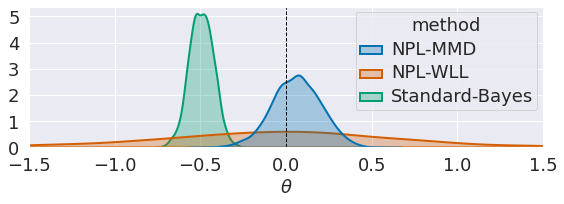

In [ ]:
compare = 3
theta_star = np.zeros(d)
p = len(theta_star)
theta_data = np.zeros(compare*B)

theta_data = np.concatenate((sample.flatten(),wll_sample.flatten(),bayes_samples.flatten()))
            
model_name_data = np.concatenate((['NPL-MMD']*B,['NPL-WLL']*B,['Standard-Bayes']*B))

columns = [] 
columns.append('method')
theta_data = np.reshape(theta_data,(p,compare*B))
df_all = pandas.DataFrame({'theta': theta_data[0,:] }) 
df_all['method'] =  model_name_data
fig, ax = plt.subplots(p, 1, figsize=(8,3))  
colors = ['#0072B2', '#D55E00', '#009E73'] 
    
sns.set(font_scale=1)
ax = sns.kdeplot(data=df_all, x="theta", linestyle="-", linewidth = 2, ax=ax, alpha=0.3,hue="method", multiple="layer", palette=colors[0:compare], shade=True, common_norm=False)
ax.set_xlabel(r'$\theta$',  fontsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
ax.set(xlim=(-1.5, 1.5))
ax.set_ylabel('')

plt.xticks(fontsize= '18')
plt.yticks(fontsize= '18')
ax.axvline(theta_star, color='black', linestyle='--', linewidth = 1)  
fig.tight_layout()

fig.savefig(results_path+'misp_plot_narrow.png')

# Toggle Switch

In [ ]:
from utils import sample_togswitch_noise
from plot_functions import plot_posterior_marg_tsols
import NPL
import models
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
data_path = "/content/drive/My Drive/NPL_MMD_experiments/data_togswitch/"
results_path = "/content/drive/My Drive/NPL_MMD_experiments/results_togswitch/"

In [ ]:
# Set model 
model_name = 'toggle_switch' 
n = 2000
d = 1
theta_star = np.array([22.,np.log(12),4.,4.5,325.,0.25,0.15])
m = 500 # number of samples
p = 7   # number of unknown parameters
B = 300 # number of bootstrap iterations 
T = 300 
model = models.toggle_switch_model(m,d,T)
R = 1 # number of independent runs
df = 1 # degrees of freedom for random noise
l = 1

In [ ]:
# Load data
datasets = np.zeros((R,n))
for j in range(R):
    X = np.loadtxt(data_path+'run_{}'.format(j))
    datasets[j,:] = X

In [ ]:
# Obtain and save results 
summary_stats = np.zeros((R, p, 4)) # collect mean, median, mode, st.dev for each bootstrap sample
times = []
for j in range(R):
    print("-----Run ", j)
    X =datasets[j,:].reshape((n,1))
    npl = NPL.npl(X,B,m,p,l, model = model, model_name = model_name)
    t0 = time.time()
    npl.draw_samples()
    sample1 = npl.sample
    npl.draw_samples()
    sample2 = npl.sample
    npl.draw_samples()
    t1 =time.time()
    total = t1-t0
    print(total)
    times.append(total)
    sample3 = npl.sample
    sample = np.vstack((sample1,sample2,sample3))
    summary_stats[j,:,0] = np.mean(sample, axis=0)
    summary_stats[j,:,1] = np.std(sample, axis=0)
    summary_stats[j,:,2] = np.median(sample, axis=0)
    summary_stats[j,:,3] = stats.mode(sample, axis=0)[0]
    np.savetxt(results_path+'thetas_mmd_run_{}.txt'.format(j), sample)
summary_stats = summary_stats.reshape((summary_stats.shape[0], -1))      
np.savetxt(results_path+'times_togswitch.txt', times)   
np.savetxt(results_path+'summary_stats.txt', summary_stats)

(<Figure size 864x432 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34e2bb6950>,
       dtype=object))

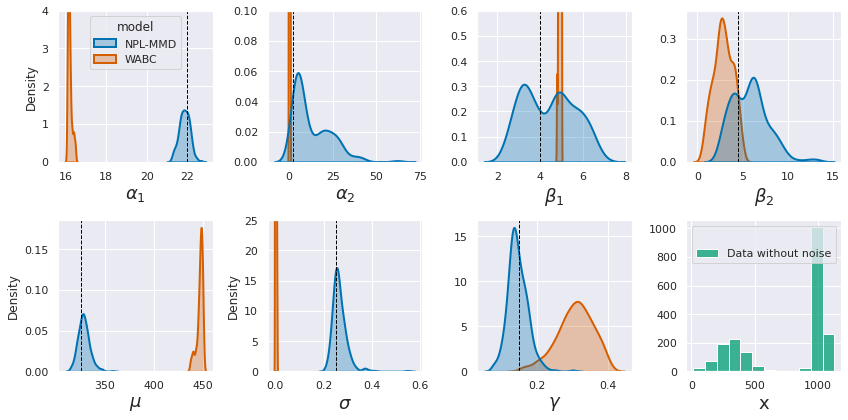

In [ ]:
 r = 0 # index which run you want results for
# Reshape results
thetas_mmd = np.zeros((p,B))
for j in range(p):
    sample = np.loadtxt(results_path+'NPL_MMD/thetas_mmd_run_{}.txt'.format(r))
    if p>1:
        thetas_mmd[j,:] = sample[:,j]
    else:
        thetas_mmd[j,:] = sample
thetas_mmd[0,:] = np.exp(thetas_mmd[0,:]) 
thetas_mmd[1,:] = np.exp(thetas_mmd[1,:]) 
thetas_mmd[4,:] = np.exp(thetas_mmd[4,:])  
thetas_mmd[5,:] = np.exp(thetas_mmd[5,:]) 
          
names = ["alpha_1", "alpha_2", "beta_1", "beta_2", "mu", "sigma", "gamma"]
thetas_wabc = np.zeros((p,B))
for i,name in enumerate(names):
    df = pd.read_csv(results_path+'WABC/thetas_wabc_run_{}.csv'.format(r))
    thetas_wabc[i,:] = df[name]
     
# Plot results
y = np.loadtxt(data_path+'run_0_y')
fname = 'run_{}_post_marg_test'.format(r)
plot_posterior_marg_tsols(B,thetas_wabc, thetas_mmd, theta_star, y,fname, save_fig=True)